In [1]:
ls data/Individual_insolvencies_by_location_2000-17_tables/

Bankruptcies 2000_2017.xlsx*       IVAs 2000_2017.xlsx*
DROs 2000_2017.xlsx*               Total insolvencies 2000_2017.xlsx*


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def party2colour(party):
    if party.startswith('Lab'):
        return 'red'
    if party.startswith('Grn'):
        return 'green'
    if party.startswith('Ind'):
        return 'grey'
    if party.startswith('LDem'):
        return 'yellow'
    if party.startswith('Con'):
        return 'blue'
    if party.startswith('UKIP'):
        return 'purple'

def clean_cols(df):
    df.columns = df.columns.str.lstrip(' ').str.rstrip(' ')
    return df
_type = 'Total'
def get_insolvencies_by_la():
    df = pd.ExcelFile(f'data/Individual_insolvencies_by_location_2000-17_tables/{_type} 2000_2017.xlsx')
    df = df.parse('Local Authorities')
    df.iloc[1] = df.iloc[1].ffill()
    df.columns = df.iloc[1].fillna('').astype(str) + ' '+ df.iloc[2].fillna('').astype(str)
    df = clean_cols(df)
    return df

def get_election_data():
    df = pd.read_csv('data/LE2018 ward-by-ward results [updated 08.05.18] - Totals.csv')
    df.iloc[0,0] = ''
    df.columns = df.iloc[1].fillna('') + ' ' + df.iloc[0].ffill()
    df = clean_cols(df)
    df = df.drop([0,1])
    df = df.replace(to_replace = '#DIV/0!', value = pd.np.nan)
    df = df.replace(to_replace = '#VALUE!', value = pd.np.nan)
    return df

In [3]:
df_insolv = get_insolvencies_by_la()

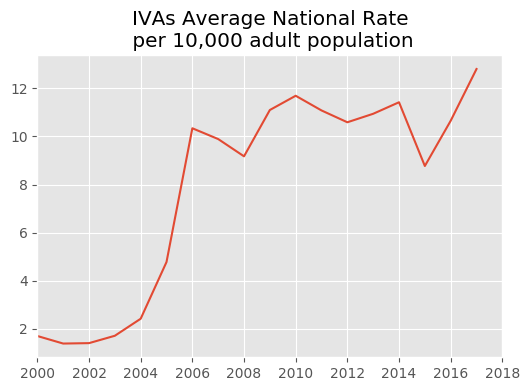

In [4]:
df_insolv_agged = df_insolv.drop([0,1,2])
df_insolv_agged = df_insolv_agged.drop(['Local Authorities'],axis=1)
df_insolv_agged = df_insolv_agged.drop(['Codes'],axis=1)

s = df_insolv_agged.mean()
per_10k = s[s.index.str.contains('Rate per 10,000 adult population')]
per_10k.index = per_10k.index.to_series().apply(lambda x : float(x.split(' ')[0]))

plt.figure(dpi=100)
plt.title(f'{_type} Average National Rate\n per 10,000 adult population')
per_10k.plot()
plt.xlim(2000,2018)
plt.savefig('images/national_insolvencies_rate.png')
plt.show()

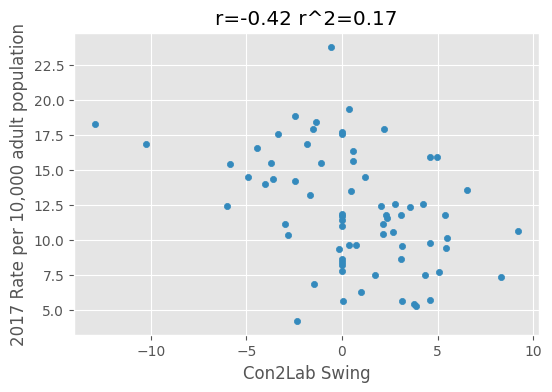

In [5]:
df_elec = get_election_data()
party_a = 'Con'
party_b = 'Lab'

df_elec[f'{party_a}2{party_b} Swing'] = (df_elec[f'{party_b} PCT +/-'].fillna(0).astype(float) - df_elec[f'{party_a} PCT +/-'].fillna(0).astype(float))/2

x_col = f'{party_a}2{party_b} Swing'
y_col = '2017 Rate per 10,000 adult population'

df_elect_lab = df_elec[['Authority',x_col]].rename(columns={'Authority' : 'Local Authorities'})
df_elect_lab['Local Authorities'] = df_elect_lab['Local Authorities'].str.replace('&','and')
df_elect_lab[x_col] = df_elect_lab[x_col].astype(float)
df_elect_lab = df_elect_lab.groupby('Local Authorities').mean().reset_index()

df_insolv_2016_nc = df_insolv.drop([0,1,2])[['Local Authorities',y_col]]

df_merged = df_elect_lab.merge(df_insolv_2016_nc,on='Local Authorities')
df_merged[[x_col, y_col]] = df_merged[[x_col, y_col]].astype(float)

fig,ax = plt.subplots(dpi=100)
df_merged.plot(ax=ax,kind='scatter',x=x_col,y=y_col)

r = df_merged.corr().iloc[0][y_col]
ax.set_title(f'r={round(r,2)} r^2={round(r**2,2)}')
plt.savefig('images/UKIP2Con.png')
plt.show()

In [6]:
df_merged.sort_values(by='2017 Rate per 10,000 adult population',ascending=False)

,Local Authorities,Con2Lab Swing,"2017 Rate per 10,000 adult population"
46,Plymouth,-0.557895,23.830660
53,Rochdale,0.370000,19.358989
66,Wigan,-2.472000,18.902929
26,Halton,-1.350000,18.449998
43,Nuneaton and Bedworth,-12.911765,18.333532
17,Crawley,-1.533333,17.945267
4,Barnsley,2.176190,17.912982
65,Weymouth and Portland,0.000000,17.723219
8,Blackburn with Darwen,0.000000,17.617945
62,Walsall,-3.337500,17.610075


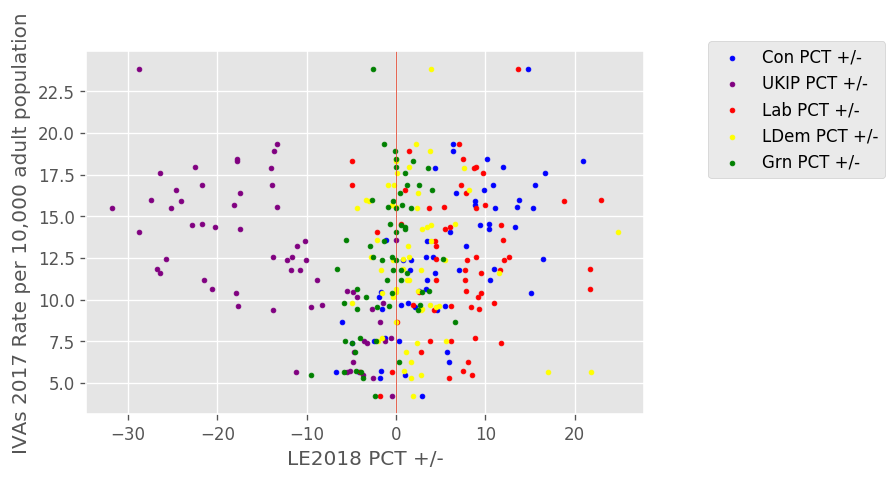

In [7]:
parties = ['Con','UKIP','Lab','LDem','Grn']
y_col = '2017 Rate per 10,000 adult population'
x_cols = [f'{party} PCT +/-' for party in parties]

df_elect_lab = df_elec[['Authority'] + x_cols].rename(columns={'Authority' : 'Local Authorities'})
df_elect_lab['Local Authorities'] = df_elect_lab['Local Authorities'].str.replace('&','and')

df_elect_lab[x_cols] = df_elect_lab[x_cols].astype(float)
df_elect_lab = df_elect_lab.groupby('Local Authorities').mean().reset_index()

df_insolv_2016_nc = df_insolv.drop([0,1,2])[['Local Authorities',y_col]]

df_merged = df_elect_lab.merge(df_insolv_2016_nc,on='Local Authorities')
df_merged[x_cols + [y_col]] = df_merged[x_cols + [y_col]].astype(float)

fig,ax = plt.subplots(dpi=120)
for x_col in x_cols:
    df_merged.plot(ax=ax,kind='scatter',x=x_col,y=y_col,label=x_col,c=party2colour(x_col),s=8)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel(_type + ' ' + y_col)
ax.set_xlabel('LE2018 PCT +/-')
plt.axvline(0,linewidth=0.5)
plt.savefig('images/all_parties_insolvencies.png')
plt.show()

In [8]:
corr = df_merged.corr()
corr['r'] = corr[y_col]
corr['r^2'] = corr[y_col]**2
corr = corr[['r','r^2']].sort_values(by='r')
print(corr[corr.r != 1.00])

                     r       r^2
UKIP PCT +/- -0.675906  0.456849
LDem PCT +/- -0.126465  0.015993
Lab PCT +/-   0.131859  0.017387
Grn PCT +/-   0.413016  0.170582
Con PCT +/-   0.699582  0.489415


In [9]:
df_merged.sort_values(by='2017 Rate per 10,000 adult population',ascending=False)

,Local Authorities,Con PCT +/-,UKIP PCT +/-,Lab PCT +/-,LDem PCT +/-,Grn PCT +/-,"2017 Rate per 10,000 adult population"
46,Plymouth,14.731579,-28.742105,13.615789,3.957895,-2.557895,23.830660
53,Rochdale,6.340000,-13.330000,7.080000,2.240000,-1.360000,19.358989
66,Wigan,6.380000,-13.620000,1.436000,3.796000,-0.129167,18.902929
26,Halton,10.200000,-17.800000,7.500000,0.000000,0.000000,18.449998
43,Nuneaton and Bedworth,20.941176,-17.852941,-4.882353,0.000000,1.864706,18.333532
17,Crawley,12.008333,-22.466667,8.941667,1.433333,0.000000,17.945267
4,Barnsley,4.371429,-13.971429,8.723810,7.652381,3.580952,17.912982
65,Weymouth and Portland,NaN,NaN,NaN,NaN,NaN,17.723219
8,Blackburn with Darwen,NaN,NaN,NaN,NaN,NaN,17.617945
62,Walsall,16.715789,-26.389474,9.689474,0.147368,1.000000,17.610075


In [10]:
# import statsmodels.api as sm

# df_merged['random'] = 0
# df_merged['random'] = np.random.uniform(size=df_merged['random'].shape)

# for x_col in ['random']:
#     Y = df_merged['2017 Rate per 10,000 adult population']
#     X = df_merged[x_col]
#     X = sm.add_constant(X)

#     model = sm.OLS(Y,X)
#     results = model.fit()
#     print(x_col)
#     print(results.t_test([1, 0]))
#     print(results.f_test(pd.np.identity(2)))

In [11]:
df_elect_lab.sort_values(by='UKIP PCT +/-')

,Local Authorities,Con PCT +/-,UKIP PCT +/-,Lab PCT +/-,LDem PCT +/-,Grn PCT +/-
5,Basildon,15.385714,-31.750000,3.635714,-4.385714,0.000000
59,Stevenage,6.000000,-28.800000,-2.100000,24.800000,0.000000
46,Plymouth,14.731579,-28.742105,13.615789,3.957895,-2.557895
2,Barking and Dagenham,13.800000,-27.458824,22.958824,-3.311765,-2.723529
71,Worthing,10.923077,-26.776923,21.661538,0.792308,-6.615385
63,Walsall,16.715789,-26.389474,9.689474,0.147368,1.000000
19,Daventry,4.416667,-26.366667,9.491667,11.508333,1.275000
1,Amber Valley,16.500000,-25.733333,4.466667,0.726667,5.286667
44,Oldham,11.125000,-25.215000,8.900000,2.395000,1.715000
60,Sunderland,9.880000,-24.584000,0.972000,8.208000,4.064000
